In [2]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
from random import randrange, uniform
%matplotlib inline
from datetime import datetime

In [3]:
os.chdir('C:/Users/Jayandran/Documents/Edwisor Questions/Project2')

In [4]:
os.getcwd()

'C:\\Users\\Jayandran\\Documents\\Edwisor Questions\\Project2'

In [5]:
#Extracting the excel file
df_cab=pd.read_csv("train_cab.csv",sep=",",encoding= "ISO-8859-1")

In [6]:
df_cab.isna().sum()

fare_amount          24
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count      55
dtype: int64

# Missing Value Analysis

In [7]:


#As there are less numbers of missing data. Neglecting it
df_cab.dropna(inplace=True)

In [8]:
df_cab.dtypes

fare_amount           object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

In [9]:
df_cab.loc[df_cab['fare_amount'] =='430-']

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
1123,430-,2009-09-22 19:01:01 UTC,-73.97961,40.771326,-73.975764,40.781965,1.0


In [10]:
#Dropping unnecessary characters
df_cab.drop(index=1123,inplace=True)

In [11]:
df_cab['fare_amount']= df_cab['fare_amount'].astype('float')

In [12]:
df_cab.dtypes

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

# Feature Engineering

In [13]:
df_cab['pickup_datetime']=df_cab['pickup_datetime'].apply(lambda x:x.replace('UTC',''))

In [14]:
df_cab['pickup_datetime'] = pd.to_datetime(df_cab['pickup_datetime'],  errors='coerce')

In [15]:
df_cab['Month']=df_cab['pickup_datetime'].dt.month

In [16]:
df_cab['Year']=df_cab['pickup_datetime'].dt.year

In [17]:
df_cab['Time in HRS']=df_cab['pickup_datetime'].dt.strftime('%H')

In [18]:
df_cab['Day']=df_cab['pickup_datetime'].dt.strftime('%a')

In [19]:
#Dropping two unrecognised dates
df_cab.dropna(inplace=True)

In [20]:
df_cab['Time in HRS']=df_cab['Time in HRS'].astype('int')

In [21]:
df_cab['Day/Night']='D'

In [22]:
#Resetting index
df_cab.reset_index(inplace=True)
#Dropping and resetting index
df_cab.drop('index',axis=1,inplace=True)

In [23]:
#Cat var for Daylight or Night
for i in range(0,len(df_cab)):
    if df_cab['Time in HRS'].iloc[i] >= 5 and df_cab['Time in HRS'].iloc[i] < 18:
        df_cab.loc[i,'Day/Night']="Day"
    elif df_cab['Time in HRS'].iloc[i] >= 18 and df_cab['Time in HRS'].iloc[i] <= 23:
         df_cab.loc[i,'Day/Night']="Night"
    else :
         df_cab.loc[i,'Day/Night']="Night"

In [24]:
from math import radians, cos, sin, asin, sqrt

In [25]:
def distance(lat1, lat2, lon1, lon2): 
      
    # The math module contains a function named 
    # radians which converts from degrees to radians. 
    lon1 = radians(lon1) 
    lon2 = radians(lon2) 
    lat1 = radians(lat1) 
    lat2 = radians(lat2) 
       
    # Haversine formula  
    dlon = lon2 - lon1  
    dlat = lat2 - lat1 
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  
    c = 2 * asin(sqrt(a))  
     
    # Radius of earth in kilometers. Use 3956 for miles 
    r = 6371
       
    # calculate the result 
    return(c * r) 

In [26]:
for i in range(0,len(df_cab)):
    dist=distance(df_cab.loc[i,'pickup_latitude'],df_cab.loc[i,'dropoff_latitude'],df_cab.loc[i,'pickup_longitude'],df_cab.loc[i,'dropoff_longitude'])
    df_cab.loc[i,'Distance_Km']=dist

In [27]:
df_cab.dtypes

fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count             float64
Month                       float64
Year                        float64
Time in HRS                   int32
Day                          object
Day/Night                    object
Distance_Km                 float64
dtype: object

In [28]:
print(df_cab['Distance_Km'].min())
df_cab['Distance_Km'].max()

0.0


8667.54210373151

In [29]:
df_cab.shape

(15986, 13)

In [30]:
df_cab=df_cab[df_cab['Distance_Km']>0]

# Outlier Analysis

{'whiskers': [<matplotlib.lines.Line2D at 0x16ed30bae80>,
 'caps': [<matplotlib.lines.Line2D at 0x16ed30caac8>,
 'boxes': [<matplotlib.lines.Line2D at 0x16ed30b7b70>],
 'medians': [<matplotlib.lines.Line2D at 0x16ed30d5a58>],
 'fliers': [<matplotlib.lines.Line2D at 0x16ed30d6128>],
 'means': []}

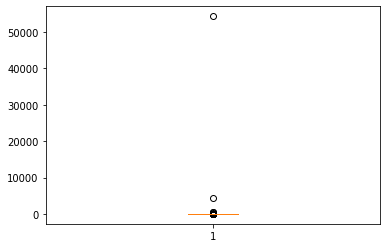

In [31]:
plt.boxplot(df_cab['fare_amount'])

In [32]:
df_cab.shape
#(15986, 12)

(15529, 13)

In [33]:
df_cab=df_cab.loc[df_cab['passenger_count']>0]

In [34]:
df_cab=df_cab.loc[df_cab['passenger_count']<=6]

In [35]:
df_cab=df_cab.loc[df_cab['pickup_latitude']< 45]

In [36]:
cnames=['pickup_longitude','dropoff_longitude','dropoff_latitude','fare_amount']
#Outlier variables

In [37]:
for i in cnames:
    print(i)
    q75,q25=np.percentile(df_cab.loc[:,i],[75,25])
    iqr = q75 - q25
    min = q25 - (iqr*1.5)
    max = q75 + (iqr*1.5)
    print(min)
    print(max)
    
    df_cab = df_cab.drop(df_cab[df_cab.loc[:,i] < min].index)
    df_cab = df_cab.drop(df_cab[df_cab.loc[:,i] > max].index)

pickup_longitude
-74.02875651250002
-73.9317292925
dropoff_longitude
-74.02913050000001
-73.9289225
dropoff_latitude
40.69094632000001
40.81382279999998
fare_amount
-2.1000000000000005
18.700000000000003


In [38]:
df_cab=df_cab[df_cab['pickup_latitude']>40]

In [39]:
df_cab.dtypes

fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count             float64
Month                       float64
Year                        float64
Time in HRS                   int32
Day                          object
Day/Night                    object
Distance_Km                 float64
dtype: object

In [40]:
df_cab['passenger_count']=df_cab['passenger_count'].round()

# Converting variables to appropriate data types

In [41]:
# Converting variables to appropriate data types
df_cab['passenger_count']=df_cab['passenger_count'].astype(object)
df_cab['Month']=df_cab['Month'].astype(object)
df_cab['Year']=df_cab['Year'].astype(object)

# Exploratory Data analysis

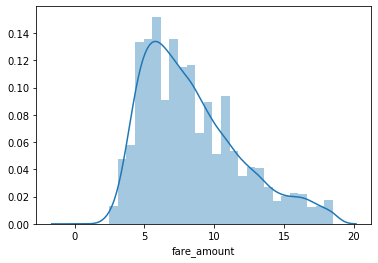

In [125]:
sns.distplot(df_cab['fare_amount'],bins=3)
#Fare amount betw 5-8 has high freq

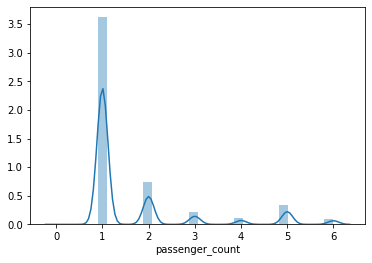

In [51]:
sns.distplot(df_cab['passenger_count'],bins=30)
#1-Passenger_count is high

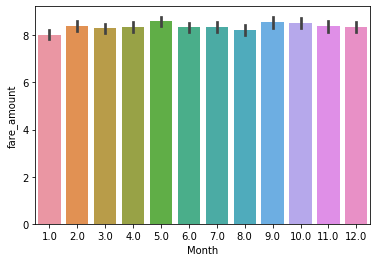

In [52]:
sns.barplot(x='Month',y='fare_amount',data=df_cab)
#Every month fare amount is fair

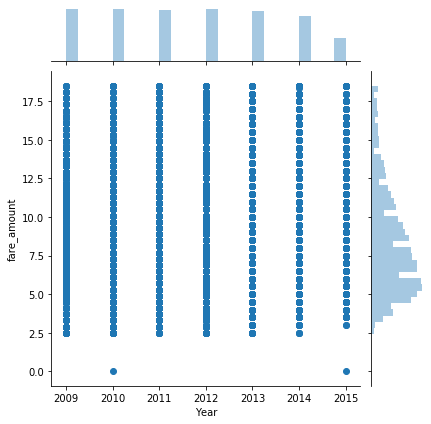

In [53]:
sns.jointplot(data=df_cab,x='Year',y='fare_amount',kind='scatter')

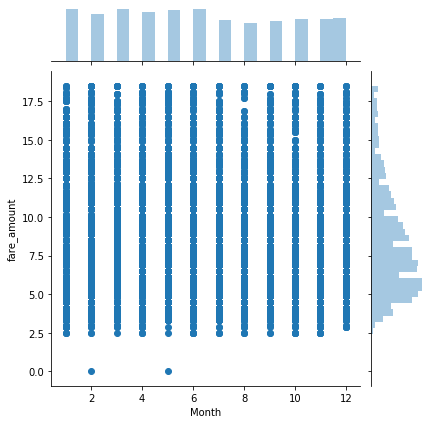

In [42]:
sns.jointplot(data=df_cab,x='Month',y='fare_amount',kind='scatter')

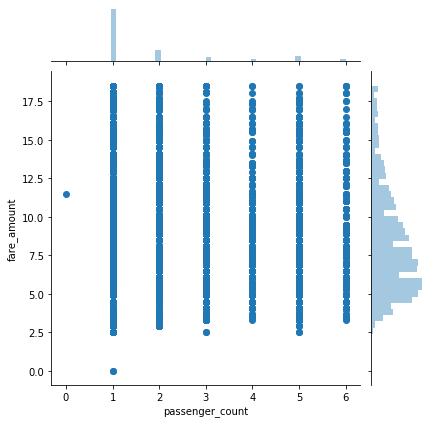

In [43]:
sns.jointplot(data=df_cab,x='passenger_count',y='fare_amount',kind='scatter')

TypeError: can't multiply sequence by non-int of type 'float'

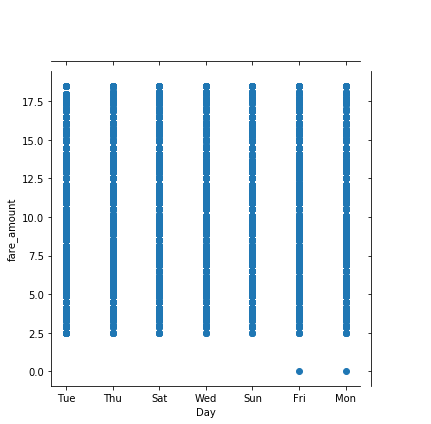

In [44]:
sns.jointplot(data=df_cab,x='Day',y='fare_amount',kind='scatter')

TypeError: can't multiply sequence by non-int of type 'float'

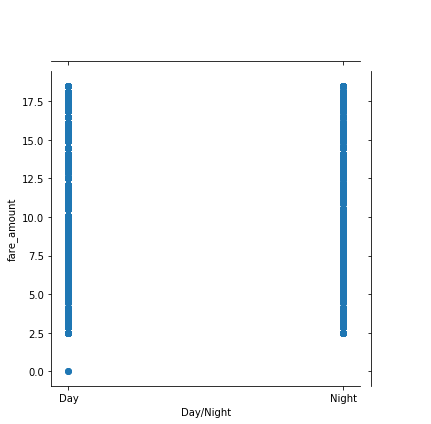

In [45]:
sns.jointplot(data=df_cab,x='Day/Night',y='fare_amount',kind='scatter')

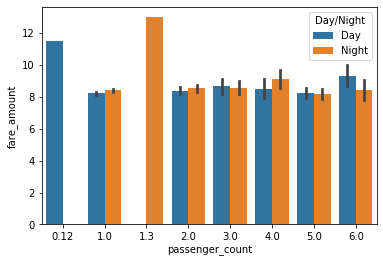

In [54]:
sns.barplot(x='passenger_count',y='fare_amount',data=df_cab,hue='Day/Night')

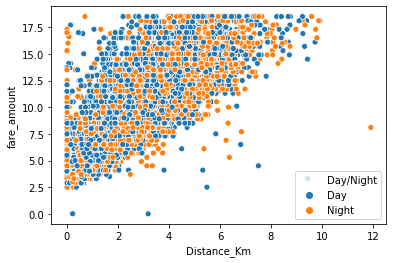

In [113]:
sns.scatterplot(x='Distance_Km', y='fare_amount', data=df_cab, hue='Day/Night')

# Correlation Analysis

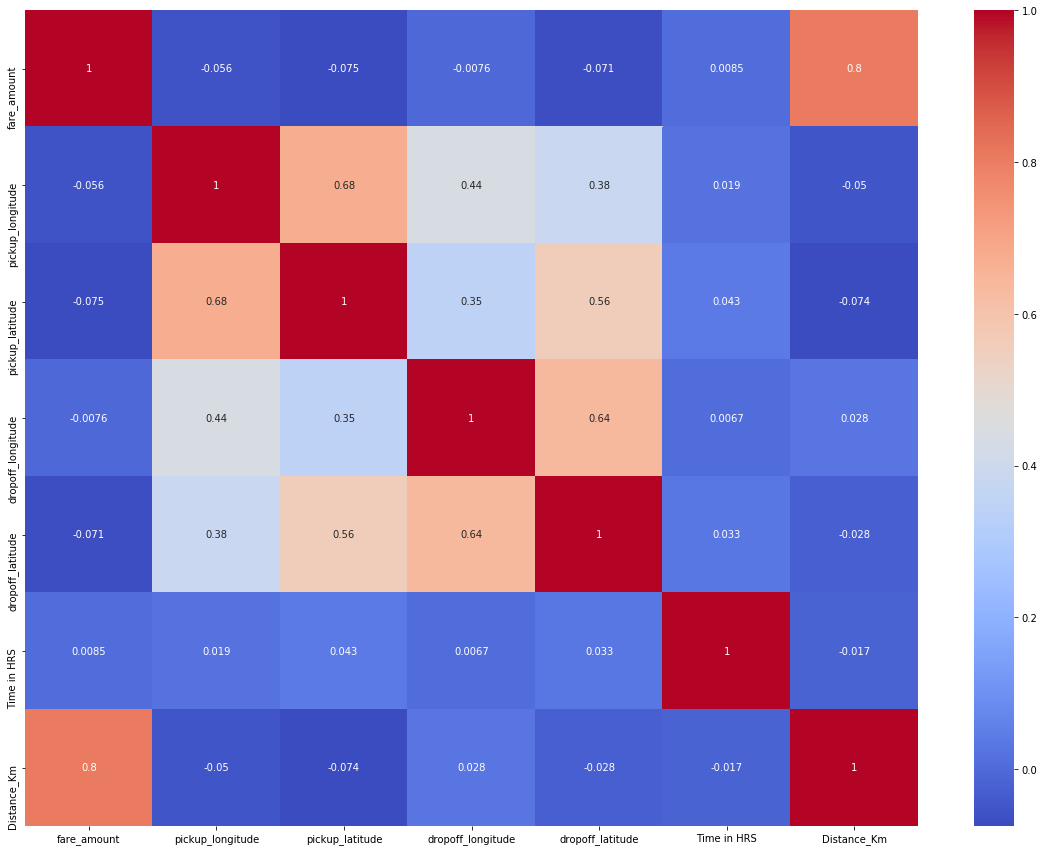

In [46]:
#Correlation Analysis
plt.subplots(figsize=(20,15))
sns.heatmap(df_cab.corr(),cmap='coolwarm',annot=True,)

In [47]:
df_cab.dtypes

fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count              object
Month                        object
Year                         object
Time in HRS                   int32
Day                          object
Day/Night                    object
Distance_Km                 float64
dtype: object

In [48]:
df_cab_original=df_cab.copy()
df_cab.fillna()

# Dimension Reduction

In [49]:
df_cab.drop(labels=['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis=1,inplace=True)

# Converting factor var to fact numeric for analysis

In [50]:
# Converting factor var to fact numeric for analysis
lis = []
for i in range(0, df_cab.shape[1]):
    #print(i)
    if(df_cab.iloc[:,i].dtypes == 'object'):
        df_cab.iloc[:,i] = pd.Categorical(df_cab.iloc[:,i])
        #print(marketing_train[[i]])
        df_cab.iloc[:,i] = df_cab.iloc[:,i].cat.codes 
        df_cab.iloc[:,i] = df_cab.iloc[:,i].astype('object')
        
        lis.append(df_cab.columns[i])
        

In [51]:
lis

['passenger_count', 'Month', 'Year', 'Day', 'Day/Night']

In [52]:
df_cab.shape

(12958, 8)

In [53]:
df_cab[df_cab['fare_amount']==0]

,fare_amount,passenger_count,Month,Year,Time in HRS,Day,Day/Night,Distance_Km
9922,0.0,1,1,1,14,1,0,3.184763


In [54]:
df_cab=df_cab[df_cab['fare_amount']>0]

In [55]:
df_cab.dtypes

fare_amount        float64
passenger_count     object
Month               object
Year                object
Time in HRS          int32
Day                 object
Day/Night           object
Distance_Km        float64
dtype: object

In [56]:
df_cab=df_cab[df_cab['passenger_count']>0]

# Creating dummies for Categorical Variables

In [57]:
Month=pd.get_dummies(df_cab['Month'],prefix='Month')
Year=pd.get_dummies(df_cab['Year'],prefix='Year')
Day=pd.get_dummies(df_cab['Day'],prefix='Day')
Day_Night=pd.get_dummies(df_cab['Day/Night'],prefix='Day/Night')
passenger_count=pd.get_dummies(df_cab['passenger_count'],prefix='passenger_count')

In [58]:
df_cab=df_cab.drop(labels=['Month','Year','Day','Day/Night','passenger_count'],axis=1)

In [59]:
df_cab=pd.concat([df_cab,Month,Year,Day,Day_Night,passenger_count],axis=1)

In [60]:
df_cab.dtypes

fare_amount          float64
Time in HRS            int32
Distance_Km          float64
Month_0                uint8
Month_1                uint8
Month_2                uint8
Month_3                uint8
Month_4                uint8
Month_5                uint8
Month_6                uint8
Month_7                uint8
Month_8                uint8
Month_9                uint8
Month_10               uint8
Month_11               uint8
Year_0                 uint8
Year_1                 uint8
Year_2                 uint8
Year_3                 uint8
Year_4                 uint8
Year_5                 uint8
Year_6                 uint8
Day_0                  uint8
Day_1                  uint8
Day_2                  uint8
Day_3                  uint8
Day_4                  uint8
Day_5                  uint8
Day_6                  uint8
Day/Night_0            uint8
Day/Night_1            uint8
passenger_count_1      uint8
passenger_count_2      uint8
passenger_count_3      uint8
passenger_coun

In [61]:
df_cab.shape

(12956, 37)

# Scatter Plot to analyze Time and fare amount to determine any peak hours. Dropping Time var as there is no peak hrs and instead additional var Day/Night is present

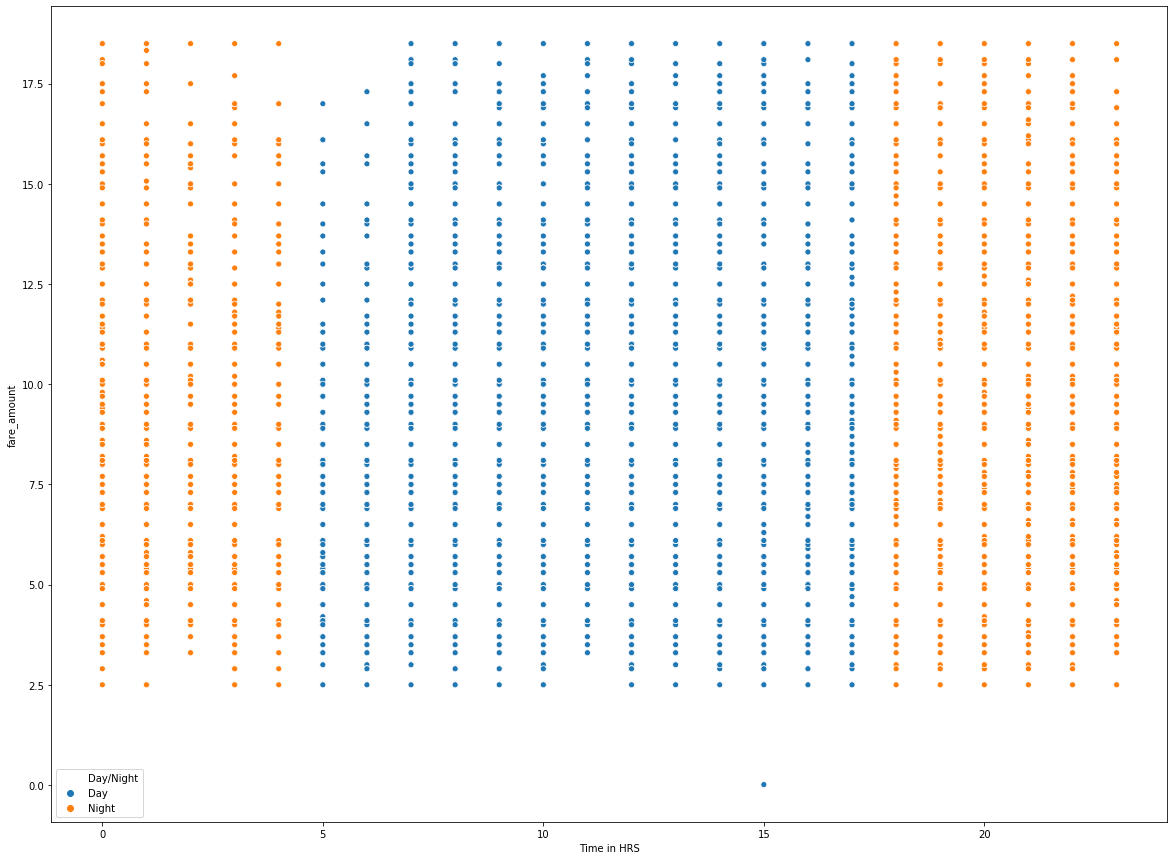

In [62]:
plt.subplots(figsize=(20,15))
sns.scatterplot(x=df_cab['Time in HRS'],y=df_cab['fare_amount'],hue=df_cab_original['Day/Night'])


In [63]:
#Dropping the Time in Hr variable as it doesn't contribute much to fareamount. There isn't actually any peak hrs. Hence deleting the var 
#as we have similar variable Day/Night.
df_cab=df_cab.drop(labels='Time in HRS',axis=1)

# Knn regression

In [64]:
#Knn regression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

In [65]:
X=df_cab.iloc[:,1:38]
y=df_cab.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [66]:
# instantiate the model and set the number of neighbors to consider to 3
knn_reg = KNeighborsRegressor(n_neighbors=8)

In [67]:
# fit the model using the training data and training targets
knn_reg.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                    weights='uniform')

In [68]:
pred_knn=knn_reg.predict(X_test)

In [69]:
#Calculate MAPE
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((y_true - y_pred) / y_true))*100
    return mape

In [70]:
MAPE(y_test, pred_knn)

34.48559146975482

# Decision Tree

In [416]:
from sklearn.model_selection import train_test_split
#Divide data into train and test
train, test = train_test_split(df_cab, test_size=0.3)

In [417]:
print(train.shape)
print(test.shape)
print(df_cab.shape)

(9069, 36)
(3887, 36)
(12956, 36)


In [418]:
#Decision Tree Model
from sklearn.tree import DecisionTreeRegressor

In [419]:
fit_DT = DecisionTreeRegressor().fit(train.iloc[:,1:37], train.iloc[:,0])

In [420]:
fit_DT

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [421]:
predictions_DT = fit_DT.predict(test.iloc[:,1:37])

In [422]:
MAPE(test.iloc[:,0], predictions_DT)

24.704286084739596

In [194]:
from sklearn import tree
#Create dot file to visualise tree  #http://webgraphviz.com/
dotfile = open("pt.dot", 'w')
df = tree.export_graphviz(fit_DT, out_file=dotfile, feature_names = df_cab.drop(labels='fare_amount',axis=1).columns)

ValueError: Length of feature_names, 36 does not match number of features, 10

# Linear Regression

In [423]:
#Import libraries for LR
#Linear Regression
import statsmodels.api as sm

In [424]:
#Divide data into train and test
train, test = train_test_split(df_cab, test_size=0.3)

In [425]:
train.shape

(9069, 36)

In [426]:
# Train the model using the training sets
model = sm.OLS(train.iloc[:,0], train.iloc[:,1:37]).fit()

In [427]:
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     647.2
Date:                Mon, 17 Feb 2020   Prob (F-statistic):               0.00
Time:                        22:35:00   Log-Likelihood:                -18912.
No. Observations:                9069   AIC:                         3.789e+04
Df Residuals:                    9038   BIC:                         3.811e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Distance_Km           1.9019      0.014    136.366      0.000       1.875       1.929
Month_0               0.0589      0.064      0.916      0.360      -0.067       0.185
Month_1               0.2627      0.067      3.908      0.000       0.131       0.395
Month_2               0.2075      0.064      3.224      0.001       0.081       0.334
Month_3               0.2191      0.066      3.322      0.001       0.090       0.348
Month_4               0.3803      0.066      5.782      0.000       0.251       0.509
Month_5               0.2264      0.065      3.506      0.000       0.100       0.353
Month_6               0.3635      0.072      5.039      0.000       0.222       0.505
Month_7               0.1091      0.075      1.457      0.145      -0.038       0.256
Month_8               0.6334      0.072      8.789      0.000       0.492       0.775
Month_9               0.5120      0.072      7.128      0.000       0.371       0.653
Month_10              0.5810      0.071      8.143      0.000       0.441       0.721
Month_11              0.5737      0.070      8.229      0.000       0.437       0.710
Year_0               -0.0960      0.049     -1.961      0.050      -0.192   -3.66e-05
Year_1               -0.2100      0.049     -4.255      0.000      -0.307      -0.113
Year_2               -0.1044      0.049     -2.134      0.033      -0.200      -0.009
Year_3                0.3697      0.049      7.546      0.000       0.274       0.466
Year_4                1.1849      0.049     23.991      0.000       1.088       1.282
Year_5                1.3260      0.051     25.885      0.000       1.226       1.426
Year_6                1.6573      0.073     22.640      0.000       1.514       1.801
Day_0                 0.7243      0.049     14.637      0.000       0.627       0.821
Day_1                 0.3594      0.053      6.778      0.000       0.255       0.463
Day_2                 0.5409      0.049     10.995      0.000       0.444       0.637
Day_3                 0.2763      0.054      5.146      0.000       0.171       0.382
Day_4                 0.7589      0.050     15.096      0.000       0.660       0.857
Day_5                 0.6689      0.051     13.158      0.000       0.569       0.769
Day_6                 0.7990      0.050     15.939      0.000       0.701       0.897
Day/Night_0           2.2593      0.032     70.759      0.000       2.197       2.322
Day/Night_1           1.8684      0.034     54.356      0.000       1.801       1.936
passenger_count_1     0.4621      0.041     11.176      0.000       0.381       0.543
passenger_count_2     0.6766      0.058     11.600      0.000       0.562       0.791
passenger_count_3     0.7892      0.092      8.536      0.000       0.608       0.970
passenger_count_4     0.7087      0.127      5.588      0.000       0.460

In [428]:
# make the predictions by the model
predictions_LR = model.predict(test.iloc[:,1:37]) 

In [429]:
#Calculate MAPE
MAPE(test.iloc[:,0], predictions_LR)

17.912057255306607

# Dist of error rate

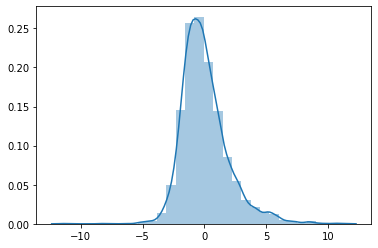

In [430]:
sns.distplot(test.iloc[:,0]-predictions_LR,bins=30)
#Seems like error is normally distributed

# Random Forest

In [1]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor

In [432]:
rand_reg=RandomForestRegressor(n_estimators=5)

In [433]:
rand_reg.fit(train.iloc[:,1:37],train.iloc[:,0])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [434]:
rand_reg_pred=rand_reg.predict(test.iloc[:,1:37])

In [435]:
#Calculate MAPE
MAPE(test.iloc[:,0], rand_reg_pred)

19.85133940497707

# Error Percentage
#Knn Reg - 43.62
#Decision Tree- 25.11
#Random Forest- 19.72
#Linear Regression- 17.97
# The best fit for the above dataset is LR.
#Hence using LR for test.csv

In [176]:
#Extracting the excel file
df_test=pd.read_csv("test.csv",sep=",",encoding= "ISO-8859-1")
df_tes=pd.read_csv("test.csv",sep=",",encoding= "ISO-8859-1")

In [177]:
df_test.isna().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

# Featue eng for test data

In [178]:
df_test['pickup_datetime']=df_test['pickup_datetime'].apply(lambda x:x.replace('UTC',''))

In [179]:
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'],  errors='coerce')

In [180]:
df_test['Month']=df_test['pickup_datetime'].dt.month

In [181]:
df_test['Year']=df_test['pickup_datetime'].dt.year

In [182]:
df_test['Time in HRS']=df_test['pickup_datetime'].dt.strftime('%H')

In [183]:
df_test['Day']=df_test['pickup_datetime'].dt.strftime('%a')

In [184]:
#Dropping two unrecognised dates
df_test.dropna(inplace=True)

In [185]:
df_test['Time in HRS']=df_test['Time in HRS'].astype('int')

In [186]:
df_test['Day/Night']='D'

In [187]:
#Resetting index
df_test.reset_index(inplace=True)
#Dropping and resetting index
df_test.drop('index',axis=1,inplace=True)

In [188]:
#Cat var for Daylight or Night
for i in range(0,len(df_test)):
    if df_test['Time in HRS'].iloc[i] >= 5 and df_test['Time in HRS'].iloc[i] < 18:
        df_test.loc[i,'Day/Night']="Day"
    elif df_test['Time in HRS'].iloc[i] >= 18 and df_test['Time in HRS'].iloc[i] <= 23:
         df_test.loc[i,'Day/Night']="Night"
    else :
         df_test.loc[i,'Day/Night']="Night"

In [189]:
from math import radians, cos, sin, asin, sqrt

In [190]:
df_test['Distance_Km']=0

In [191]:
for i in range(0,len(df_test)):
    dist=distance(df_test.loc[i,'pickup_latitude'],df_test.loc[i,'dropoff_latitude'],df_test.loc[i,'pickup_longitude'],df_test.loc[i,'dropoff_longitude'])
    df_test.loc[i,'Distance_Km']=dist

In [192]:
df_test.dtypes

pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
Month                         int64
Year                          int64
Time in HRS                   int32
Day                          object
Day/Night                    object
Distance_Km                 float64
dtype: object

In [193]:
#Converting variables to appropriate data types
df_test['passenger_count']=df_test['passenger_count'].astype(object)
df_test['Month']=df_test['Month'].astype(object)
df_test['Year']=df_test['Year'].astype(object)

In [194]:
df_test.drop(labels=['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','Time in HRS'],axis=1,inplace=True)

In [195]:
# Converting factor var to fact numeric for analysis
lis = []
for i in range(0, df_test.shape[1]):
    #print(i)
    if(df_test.iloc[:,i].dtypes == 'object'):
        df_test.iloc[:,i] = pd.Categorical(df_test.iloc[:,i])
        #print(marketing_train[[i]])
        df_test.iloc[:,i] = df_test.iloc[:,i].cat.codes 
        df_test.iloc[:,i] = df_test.iloc[:,i].astype('object')
        
        lis.append(df_test.columns[i])
        

In [196]:
lis

['passenger_count', 'Month', 'Year', 'Day', 'Day/Night']

In [197]:
df_test.shape

(9914, 6)

In [198]:
Month=pd.get_dummies(df_test['Month'],prefix='Month')
Year=pd.get_dummies(df_test['Year'],prefix='Year')
Day=pd.get_dummies(df_test['Day'],prefix='Day')
Day_Night=pd.get_dummies(df_test['Day/Night'],prefix='Day/Night')
passenger_count=pd.get_dummies(df_test['passenger_count'],prefix='passenger_count')

In [199]:
df_test=df_test.drop(labels=['Month','Year','Day','Day/Night','passenger_count'],axis=1)

In [200]:
df_test=pd.concat([df_test,Month,Year,Day,Day_Night,passenger_count],axis=1)

In [201]:
df_test.shape

(9914, 35)

# Predicting using LR model

In [202]:
# make the predictions by the model
predictions_LR_test = model.predict(df_test.iloc[:,0:36]) 

In [203]:
df_test['fare_amount']=predictions_LR_test

In [204]:
df_tes['fare_amount']=predictions_LR_test
df_tes['Distance_Km']=df_test['Distance_Km']

# Writing the csv file with predicted fare amount

In [205]:
df_tes.to_csv("Original_with_fare&Dist_python.csv",index=False)

In [206]:
df_test.to_csv("Detailed_with_fare_python.csv",index=False)